In [3]:
import pysr

In [4]:
import warnings
warnings.filterwarnings('ignore')

import sympy
import numpy as np
import pandas as pd
import skill_metrics as sm
import mpl_scatter_density # adds projection='scatter_density'

from pysr import PySRRegressor
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Set up data:


using Sergio's data

In [13]:
df = pd.read_csv(r"C:\github\PySR_ATeam_sac\examples\LAI_vineyard_equations\Data\03_df_bands_structure_VI_LAI_NDVIc.csv")
# print(df.head())
cols_to_keep = ["CH", "FC", "GCC", "NDYI", "BNDVI","IKAW"]
new_df = df[cols_to_keep].copy()

X = new_df
y = df.LAI
print(X.head())
print(y.head())
# X.head()

         CH        FC       GCC      NDYI     BNDVI      IKAW
0  1.972603  0.439236  0.566442  0.819944  0.969314  0.741484
1  1.946317  0.383681  0.566639  0.817755  0.969251  0.737816
2  1.988539  0.274306  0.550471  0.820092  0.968551  0.757917
3  2.024439  0.307292  0.547428  0.822196  0.968145  0.763943
4  1.946801  0.130208  0.533091  0.799422  0.961771  0.745464
0    1.47
1    1.50
2    1.18
3    1.16
4    1.19
Name: LAI, dtype: float64


In [1]:
import joblib
model = joblib.load(r"C:\github\PySR_ATeam_sac\examples\LAI_vineyard_equations\M1_NDVIc_best3\outputs\20260125_155836_QXFb6i\checkpoint.pkl")

# You can still access the hall of fame
print(model.equations_)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
    complexity      loss                                           equation  \
0            1  1.291319                                           2.367226   
1            3  0.673516                                      3.435736 / CH   
2            5  0.448900                              2.5137253 / (CH - FC)   
3            7  0.373378                 ((FC - CH) * 2.3525321) + 5.184006   
4            9  0.366566  ((4.307768 - CH) * (FC - -1.9895318)) + -4.080408   
5           11  0.334650  ((FC - CH) * 2.363661) + ((-0.006059851 / FC) ...   
6           13  0.310832  (((FC - CH) - -2.1668458) / GCC) + (-0.0801763...   
7           15  0.263903  (-0.12658815 / (0.5616777 - NDYI)) + (((FC + (...   
8           17  0.238901  (FC + (((((-0.050067276 / (0.54129934 - NDYI))...   
9           19  0.224598  (-0.1987565 / (0.46661502 - IKAW)) + (((((FC -...   
10          21  0

We can print the model pareto curve, which will showcase the trend of discovered solutions:

In [2]:
best_score=model.get_best().score

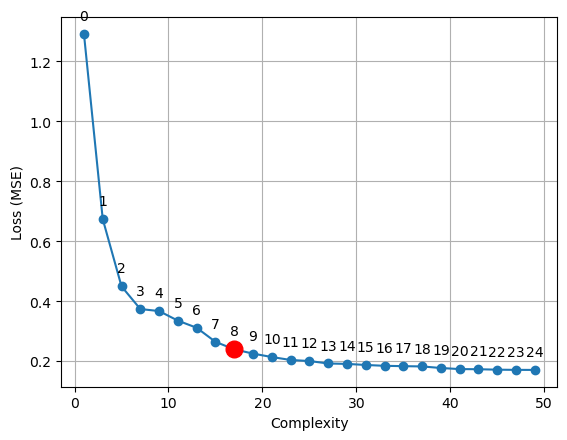

In [14]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
# max_index = scores.idxmax(axis=0)
max_index = scores == best_score
max_index


pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [15]:
unique_max_index = max_index[max_index].index.tolist()
model.sympy(unique_max_index[0])  # get the selected equation in sympy format

(CH*(-0.73885125 - 0.050067276/(0.54129934 - NDYI)) + FC - IKAW - 1*(-1.9463075))/0.37498376

In [16]:
# Inspect `model.equations_` structure
print('model.equations_.columns ->', model.equations_.columns.tolist())
# show the top rows for quick inspection
try:
    display(model.equations_.head())
except Exception:
    print(model.equations_.head())

model.equations_.columns -> ['complexity', 'loss', 'equation', 'score', 'sympy_format', 'lambda_format']


,complexity,loss,equation,score,sympy_format,lambda_format
0,1,1.291319,2.367226,0.000000,2.36722600000000,PySRFunction(X=>2.36722600000000)
1,3,0.673516,3.435736 / CH,0.325454,3.435736/CH,PySRFunction(X=>3.435736/CH)
2,5,0.448900,2.5137253 / (CH - FC),0.202856,2.5137253/(CH - FC),PySRFunction(X=>2.5137253/(CH - FC))
3,7,0.373378,((FC - CH) * 2.3525321) + 5.184006,0.092105,(-CH + FC)*2.3525321 + 5.184006,PySRFunction(X=>(-CH + FC)*2.3525321 + 5.184006)
4,9,0.366566,((4.307768 - CH) * (FC - -1.9895318)) + -4.080408,0.009206,(4.307768 - CH)*(FC - 1*(-1.9895318)) - 4.080408,PySRFunction(X=>(4.307768 - CH)*(FC - 1*(-1.98...


We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [17]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.291319,2.367226
1,0.673516,3.435736 / CH
2,0.448900,2.5137253 / (CH - FC)
3,0.373378,((FC - CH) * 2.3525321) + 5.184006
4,0.366566,((4.307768 - CH) * (FC - -1.9895318)) + -4.080408
5,0.334650,((FC - CH) * 2.363661) + ((-0.006059851 / FC) - -5.243057)
6,0.310832,(((FC - CH) - -2.1668458) / GCC) + (-0.08017631 / (0.49488294 - IKAW))
7,0.263903,(-0.12658815 / (0.5616777 - NDYI)) + (((FC + (BNDVI - IKAW)) * 3.550959) / CH)
8,0.238901,(FC + (((((-0.050067276 / (0.54129934 - NDYI)) + -0.73885125) * CH) - IKAW) - -1.9463075)) / 0.37498376
9,0.224598,(-0.1987565 / (0.46661502 - IKAW)) + (((((FC - IKAW) - (CH * 0.6119851)) / BNDVI) - -2.0081608) / GCC)


## Output

Plotting the first solutions

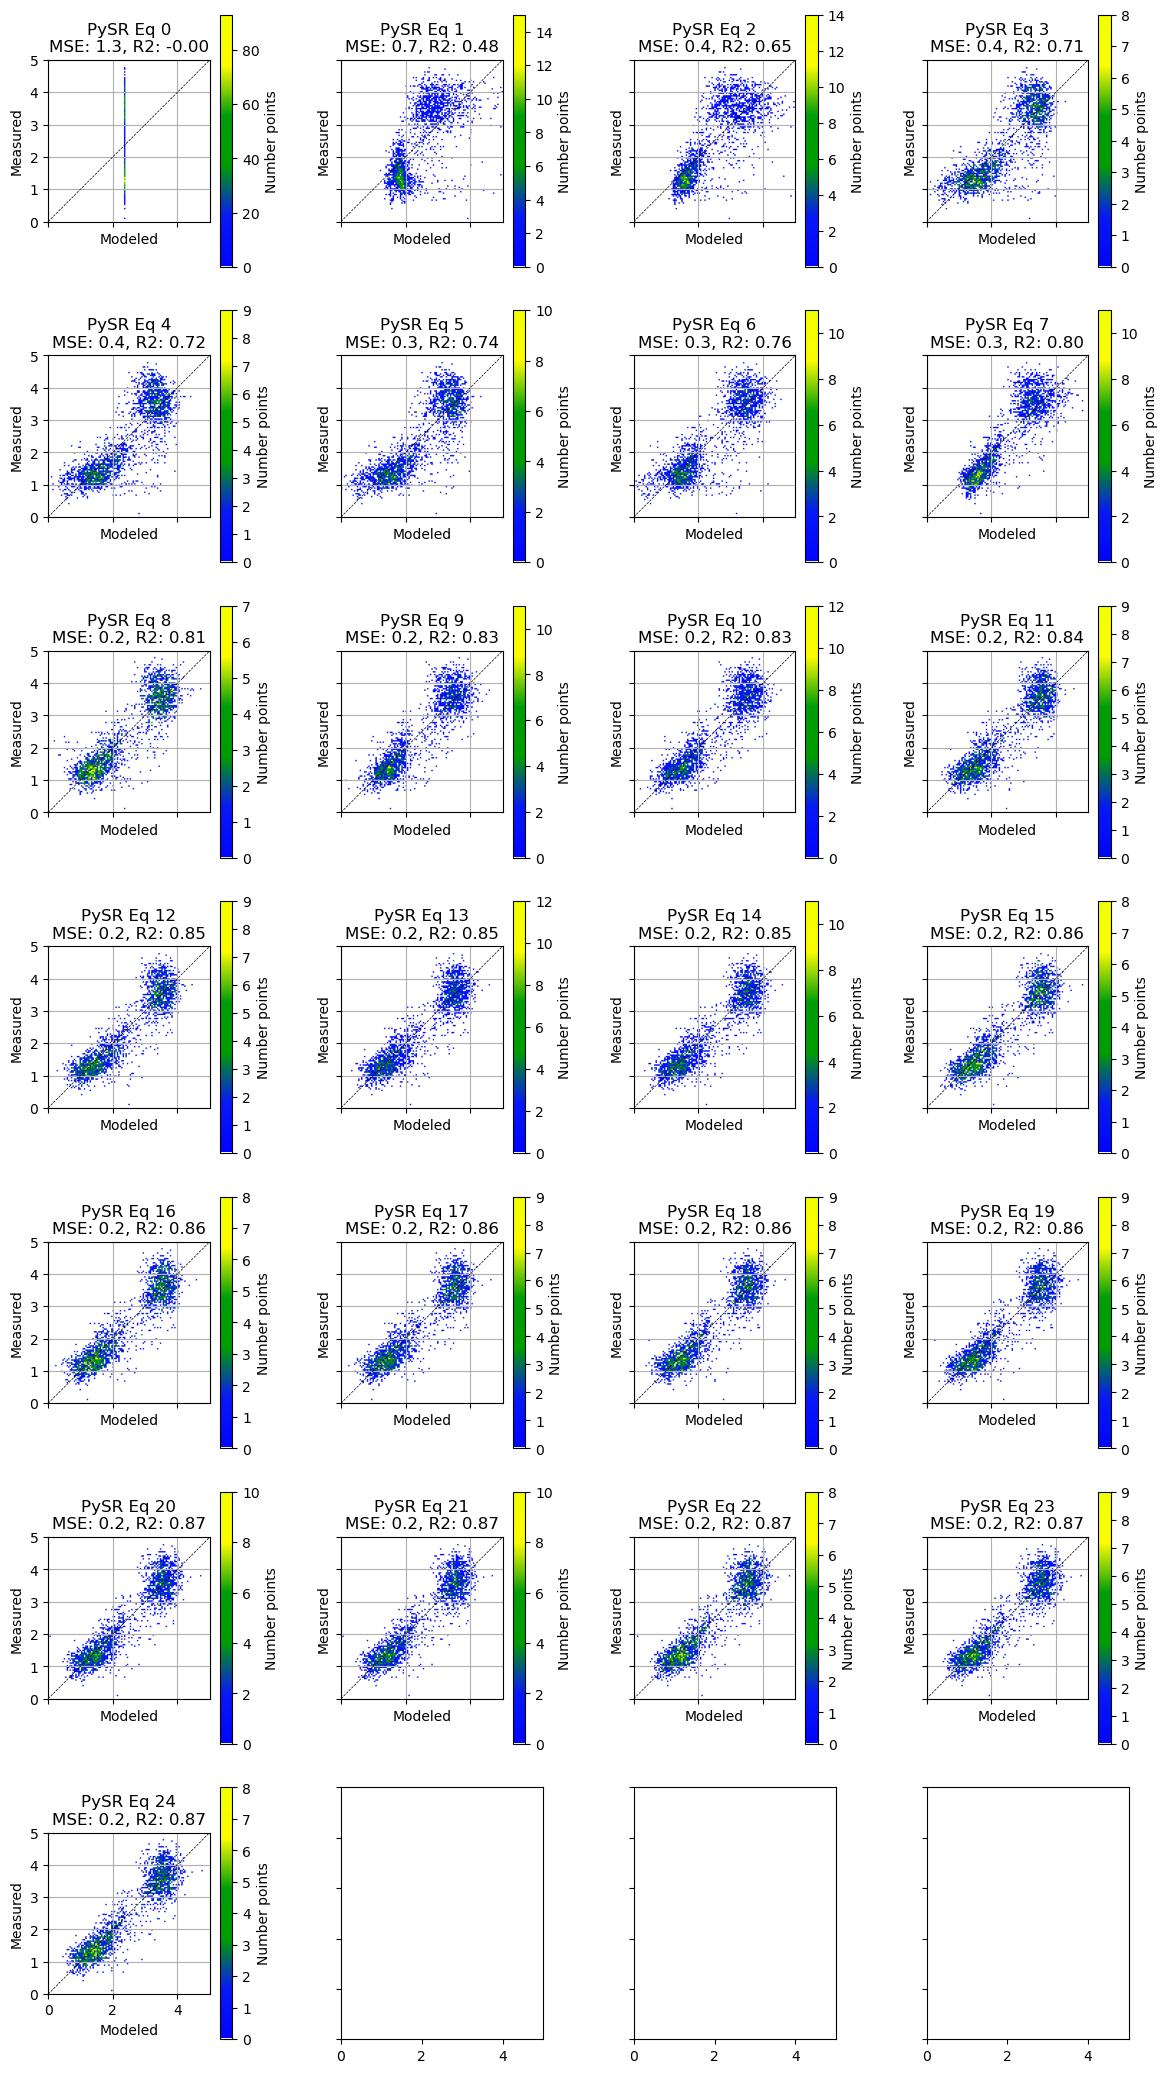

In [18]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, "#0004FF"),
    (0.2, "#0818F6"),
    (0.4, "#009d00"),
    (0.6, "#009d0a"),
    (0.8, "#fcfc01"),
    (1, "#f2ff00"),
], N=256)

num_eq = len(model.equations_)

fig_rows = int(np.ceil(num_eq / 4))
fig_cols = 4

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True,subplot_kw=dict(projection="scatter_density"))

it = np.linspace(0,num_eq-1,num_eq, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    # ypredict_simpler = pd.Series(np.asarray(ypredict_simpler).ravel(), index=y.index)

    density=ax.scatter_density(ypredict_simpler, y, cmap=white_viridis)

    # ax.plot(ypredict_simpler, y,'.')

    ax.grid(True)
    ax.set_xlabel("Modeled")
    ax.set_ylabel("Measured")
    ax.plot( [0,5], [0,5], linestyle='--', color='k', linewidth=0.5 )
    fig.colorbar(density, label='Number points', ax=ax)

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    mse = mean_squared_error(ypredict_simpler, y)
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nMSE: {mse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

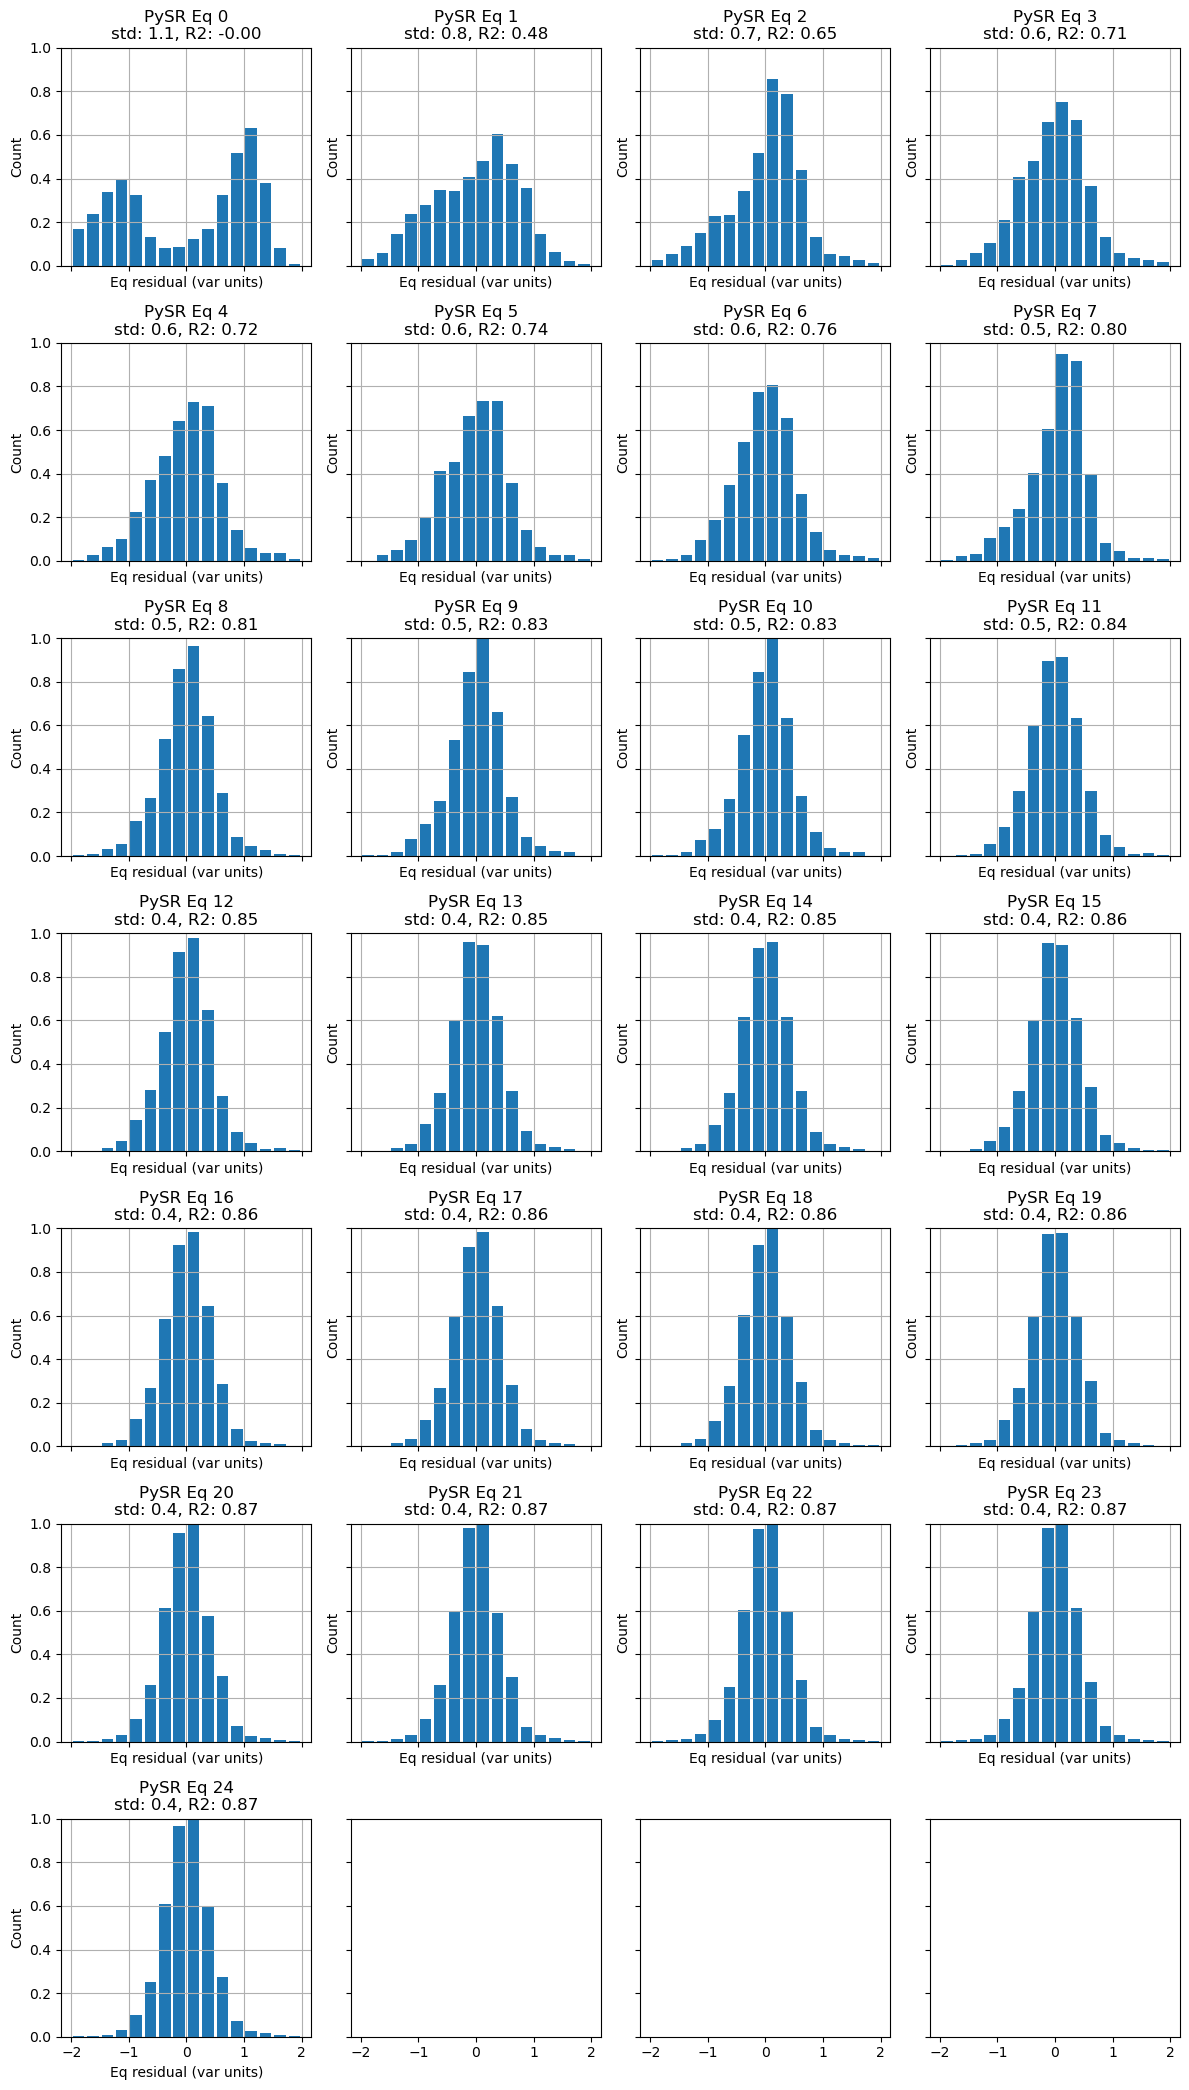

In [19]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True)

# Define bin interval and create bin edges
bin_interval = 0.25  # Adjust this value to change bin width
bins = np.arange(-2, 2 + bin_interval, bin_interval)

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y, bins=bins, density=True, rwidth=0.8)
    ax.grid(True)
    ax.set_xlabel("Eq residual (var units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )
    ax.set_ylim(0, 1)

    N = len(y)
    mean = np.mean(ypredict_simpler - y)
    ddof = 1  # Use sample standard deviation
    d2 = abs(ypredict_simpler- y - mean)**2  # abs is for complex `a`
    var = d2.sum() / (N - ddof)  # note use of `ddof`
    std = var**0.5
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Create a Taylor diagram with labeled data points and modified axes

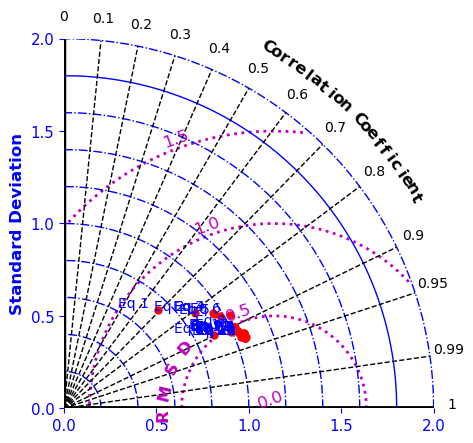

In [20]:

    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

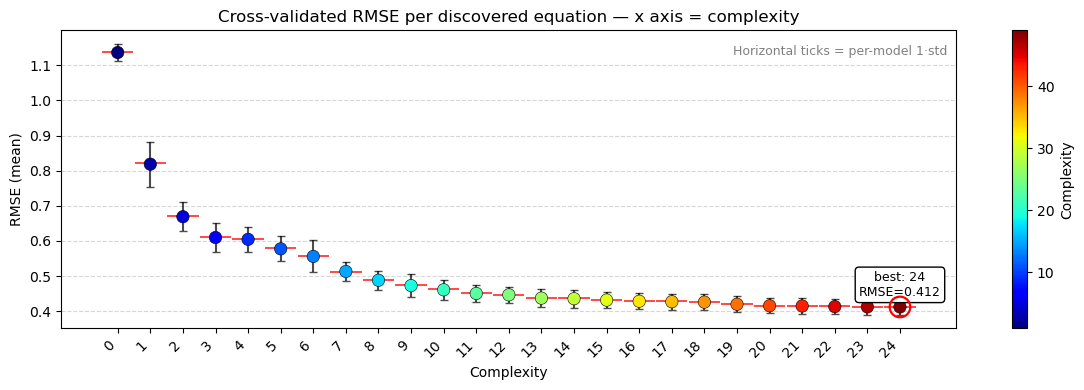

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

kf = KFold(n_splits=10, shuffle=True, random_state=0)
eq_indices = list(model.equations_.index)        # indices of discovered equations
scores = {idx: [] for idx in eq_indices}
residuals = {idx: [] for idx in eq_indices}  # collect residuals across folds for each equation

# Use explicit dataset target to avoid accidental shadowing of `y`
y_target = df.iloc[:, -2]

for _, test_idx in kf.split(X):
    X_test = X.iloc[test_idx]
    # handle y_target as pandas Series or numpy array
    if hasattr(y_target, "iloc"):
        y_test = y_target.iloc[test_idx]
    else:
        y_test = np.asarray(y_target)[test_idx]

    for idx in eq_indices:
        ypred = model.predict(X_test, index=idx)
        # ensure numpy arrays and flatten
        y_test_arr = np.asarray(y_test).ravel()
        ypred_arr = np.asarray(ypred).ravel()
        # RMSE per fold (kept for backward compatibility)
        scores[idx].append(np.sqrt(mean_squared_error(y_test_arr, ypred_arr)))
        # collect residuals for final std calculation
        residuals[idx].extend((y_test_arr - ypred_arr).tolist())

# summarize
rows = []
for idx in eq_indices:
    # compute residual std across all test predictions from CV folds
    try:
        resid_std = np.std(np.asarray(residuals[idx]), ddof=1)
    except Exception:
        resid_std = np.nan

    rows.append({
        "index": idx,
        "rmse_mean": np.mean(scores[idx]),
        "rmse_std": np.std(scores[idx], ddof=1),
        "resid_std": resid_std,
        "complexity": model.equations_.loc[idx, "complexity"],
        "equation": model.equations_.loc[idx, "equation"],
    })

df_cv = pd.DataFrame(rows).sort_values("rmse_mean")

# show top 10 by mean RMSE
# display(df_cv.head(10))

# --- Plot: rmse_mean vs. complexity (colored by complexity) -----------
# sort for plotting by numeric `complexity` so x-axis shows complexity order
plot_df = df_cv.sort_values("complexity").reset_index(drop=True)

x = plot_df["complexity"].values
labels = plot_df["index"].astype(str)
y_vals = plot_df["rmse_mean"].values
yerr = plot_df["rmse_std"].fillna(0).values
comp = plot_df["complexity"].values

fig, ax = plt.subplots(figsize=(12, 4))
# draw vertical error bars first (no markers)
ax.errorbar(x, y_vals, yerr=yerr, fmt='none', ecolor='black', alpha=0.7, capsize=3)
# scatter points colored by complexity
sc = ax.scatter(x, y_vals, c=comp, cmap='jet', s=80, edgecolor='k', linewidth=0.4, zorder=3)
# add colorbar for complexity
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Complexity')

# show equation index as tick labels at each complexity position
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Complexity')
ax.set_ylabel('RMSE (mean)')
ax.set_title('Cross-validated RMSE per discovered equation — x axis = complexity')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# draw small horizontal ticks at each model's 1·std value
# choose width as a small fraction of x span so ticks remain compact
if len(x) > 1:
    x_span = np.max(x) - np.min(x)
    width = max(x_span * 0.02, 0.1)
else:
    width = 0.1
# use per-model residual std values if present, otherwise fall back to rmse_std
resid_vals = plot_df.get("resid_std", plot_df.get("rmse_std")).fillna(0).values
ax.hlines(y=resid_vals, xmin=x - width, xmax=x + width, colors='red', alpha=0.8, linewidth=1.25, zorder=2)

# highlight best (lowest mean RMSE)
best_pos = np.nanargmin(y_vals)
best_x = x[best_pos]
ax.scatter(best_x, y_vals[best_pos], facecolors='none', edgecolors='red', s=220, linewidth=1.6, zorder=5)
ax.annotate(f"best: {plot_df.loc[best_pos, 'index']}\nRMSE={y_vals[best_pos]:.3f}",
            xy=(best_x, y_vals[best_pos]), xytext=(0, 8), textcoords='offset points',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', fc='w'))

# label what the horizontal ticks represent
ax.text(0.99, 0.95, 'Horizontal ticks = per-model 1·std', transform=ax.transAxes,
        ha='right', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api